### Hand-crafted graph features

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from attr.validators import max_len

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

#### На самом деле можно просто взять и сгенерировать набор графов, которые можно классифицировать - циклические и ациклические, двудольные графы и все остальные и т.д. Но я все же возьму реальный датасет с графами, которые можно классифицировать.
#### Я взял графы с химическими данными, чтобы сначала просто посмотреть, что он из себя представляет - для этого использую torch_geometric.datasets

In [2]:
from torch_geometric.datasets import MoleculeNet

# Импортировали датасет - и загрузились данные
dataset = MoleculeNet(root='./data', name='bace')

#### Что это за данные: это данные с соединениями и метками, ингибирует ли соединение или не ингибирует секретазу BACE-1; т е соединения либо подавляют фермент, отвечающий за болезнь Альцгеймера, либо не подавляют

#### Если просто вывести датасет - будет только информация о названии и о том, сколько там вообще графов

In [3]:
display(dataset)

BACE(1513)

#### Выведем информацию в виде датафрейма; если еще что-то понадобится - просто дополним новыми строками

In [4]:
display(pd.DataFrame([[dataset, len(dataset), dataset.num_node_features, dataset.num_edge_features, dataset.num_classes]],
                     columns=["Датасет",
                              "Количество графов",
                              "Количество признаков вершин",
                              "Количество признаков ребер",
                              "Количество классов"]).T)


# Действительно, видим 2 класса - отлично, будем решать задачу бинарной классификации

,0
Датасет,"([(x, tensor([[8, 0, 2, 5, 0, 0, 4, 0, 1],\n ..."
Количество графов,1513
Количество признаков вершин,9
Количество признаков ребер,3
Количество классов,2


#### Тут имеется ввиду, что саму вершину описывает какие-то 9 признаков (они описывают атом), и ребра описывают 3 признака (т е признаки описывают соединения)

#### Теперь посмотрим на распределение первичных признаков (например, на распределение количества вершин и количества ребер) в представленном датасете

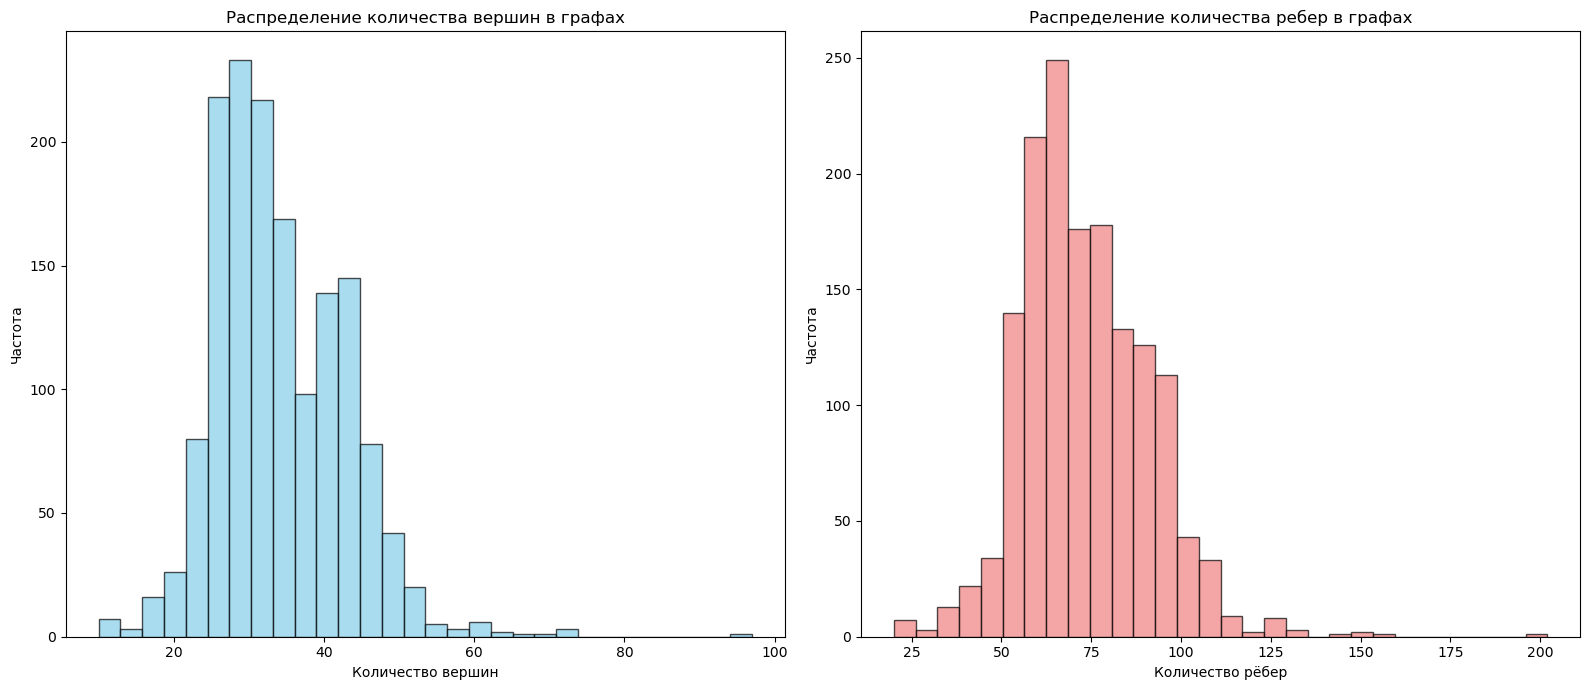

In [5]:
node_cnt = [data.num_nodes for data in dataset]
edge_cnt = [data.num_edges for data in dataset]

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
plt.hist(node_cnt, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Количество вершин')
plt.ylabel('Частота')
plt.title('Распределение количества вершин в графах')

plt.subplot(1, 2, 2)
plt.hist(edge_cnt, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Количество рёбер')
plt.ylabel('Частота')
plt.title('Распределение количества ребер в графах')

plt.tight_layout()
plt.show()

#### С точки зрения количества вершин нельзя сказать, что графы очень большие, с точки зрения количества ребер тем более - полные графы там вряд ли есть, ребер немного; также судя по гистограммам выше, распределение и количества вершин, и количества ребер похоже на нормальное +-, что хорошо

### Визуализируем и посмотрим на отдельно взятый граф

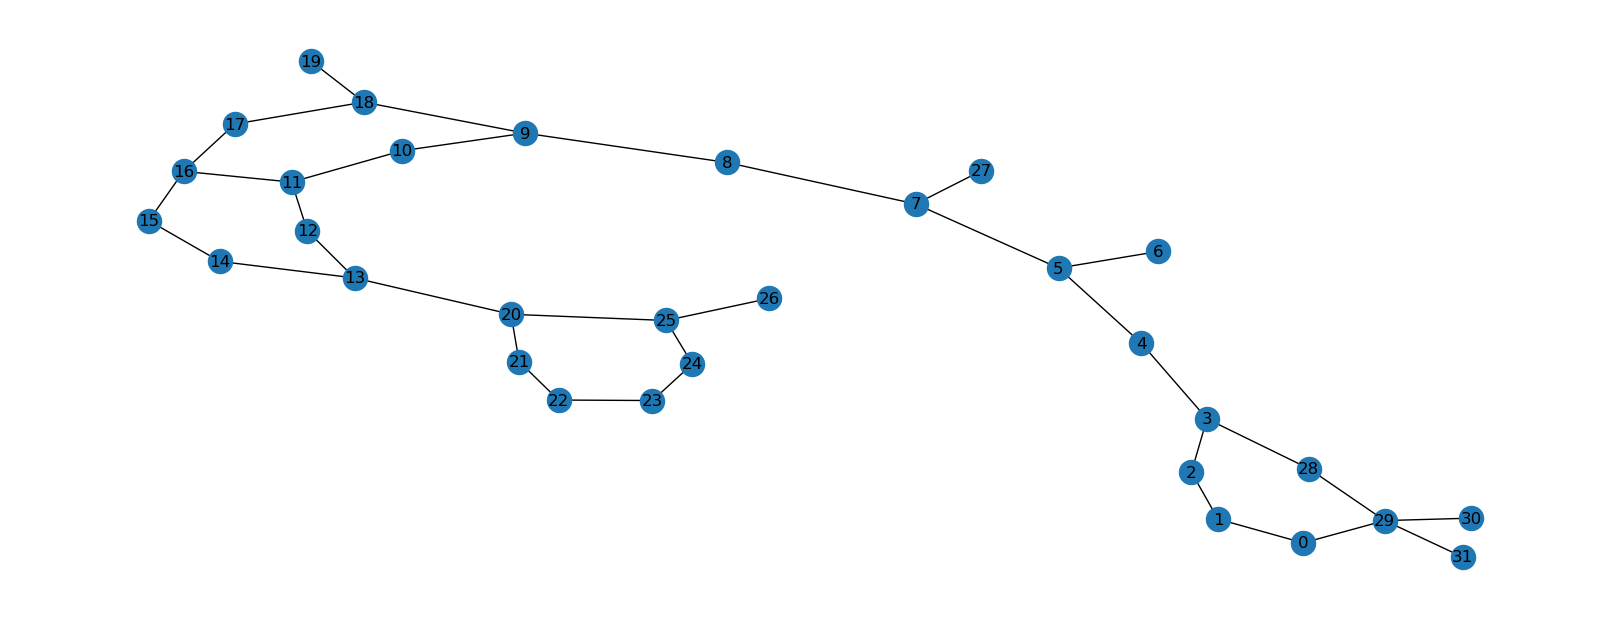

In [6]:
from torch_geometric.utils import to_networkx
my_graph = to_networkx(dataset[0], to_undirected=True)
plt.figure(figsize=(16, 6))

nx.draw(my_graph, with_labels=True)

In [7]:
dataset[0]

Data(x=[32, 9], edge_index=[2, 70], edge_attr=[70, 3], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C', y=[1, 1])

#### И визуализируем саму молекулу:

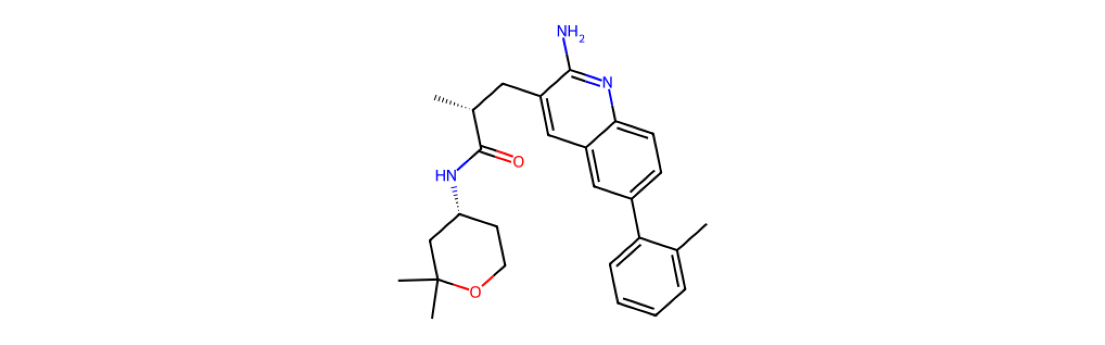

In [8]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

smiles = dataset[0].smiles

# Создание молекулы из SMILES
mol = Chem.MolFromSmiles(smiles)

# Визуализация
img = Draw.MolToImage(mol, size=(1000, 300))
plt.figure(figsize=(14, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

### Вычисление признаков и обучение модели

#### Мы сделали первичный анализ датасета; теперь надо скрафтить признаки (в том числе, вектор из количества различных кратчайших путей различной длины); обучить модель классификации графов и подобрать оптимальные гиперпараметры

In [9]:
from sklearn.model_selection import train_test_split

# Разделим наш датасет на тренировочную и тестовую части заранее со стратификацией - для того чтобы сбалансированные выборки были

indices = np.arange(len(dataset))
test_size = 0.2

labels = [data.y.item() if data.y.dim() == 0 else data.y[0].item() for data in dataset]

train_idx, test_idx = train_test_split(
    indices,
    test_size=test_size,
    stratify=labels,
    random_state=15
)

train_dataset, test_dataset = dataset[train_idx.tolist()], dataset[test_idx.tolist()]


In [10]:
# Сразу и начнем - поэтапно реализуем функцию shortest_path_kernel(train_graphs, test_graphs)

# nx.shortest_path_length возвращает не совсем то - нам надо именно для каждой длины посчитать, сколько раз она встречалась


def my_path_features(G):
    G = to_networkx(G, to_undirected=True)
    paths = nx.shortest_path_length(G)
    result = {}
    for node in paths:
        for path_len in node[1].values():
            if path_len not in result:
                result[path_len] = 1
            else:
                result[path_len] += 1
    return list(result.values())


def shortest_path_kernel(train_graphs, test_graphs):
    # Количества кратчайших путей различной длины
    train_data = [my_path_features(G) for G in train_graphs]
    test_data = [my_path_features(G) for G in test_graphs]

    # У нас же ненаправленный граф, а значит получившиеся значения можно на 2 поделить - но с точки зрения решения задачи этот множитель вряд ли на что-то влияет

    # Очевидно, что выше хранятся вектора разной длины - приведем все к одной длине, заполнив недостающие значения нулями

    max_len = max(len(max(train_data, key=len)), len(max(test_data, key=len)))

    train_data = np.array([np.pad(value, (0, max_len - len(value)), constant_values=0) for value in train_data])
    test_data = np.array([np.pad(value, (0, max_len - len(value)), constant_values=0) for value in test_data])


    # Теперь - надо возвращать матрицы из ядровых функций (скалярное произведение векторов)
    K_train = train_data@train_data.T
    K_test = test_data@train_data.T

    return K_train, K_test


K_train, K_test = shortest_path_kernel(train_dataset, test_dataset)


#### На примере тренировочного набора посмотрим, что получилось:

In [11]:
display(K_train.shape, K_test.shape)

(1210, 1210)

(303, 1210)

#### Теперь - реализация SVC

In [12]:
# Выше мы отдельно метки классов не выделили, создадим для них отдельные переменные

train_labels = [data.y.item() if data.y.dim() == 0 else data.y[0].item() for data in train_dataset]
test_labels = [data.y.item() if data.y.dim() == 0 else data.y[0].item() for data in test_dataset]

In [13]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

### Сначала - без подбора гиперпараметров
model_svc = SVC(kernel='precomputed')

model_svc.fit(K_train, train_labels)

predictions = model_svc.predict(K_test)

# Ну в целом неплохо
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.73      0.69      0.71       165
         1.0       0.65      0.70      0.67       138

    accuracy                           0.69       303
   macro avg       0.69      0.69      0.69       303
weighted avg       0.70      0.69      0.69       303



In [19]:
# Теперь - с GridSearch и подбором гиперпараметров

from sklearn.model_selection import GridSearchCV

params =  {'C': np.arange(0.1, 1.2, 0.1), 'kernel': ['rbf', 'poly']}

grid_search_svc = GridSearchCV(
    model_svc,
    params,
    cv=4,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search_svc.fit(K_train, train_labels)

Fitting 4 folds for each of 22 candidates, totalling 88 fits


GridSearchCV(cv=4, estimator=SVC(kernel='precomputed'), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
                         'kernel': ['rbf', 'poly']},
             scoring='f1', verbose=2)

In [21]:
# Лучше, почему-то, не стало - но все равно неплохо
grid_prediction = grid_search_svc.predict(K_test)
print(classification_report(test_labels, grid_prediction))

              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68       165
         1.0       0.62      0.59      0.61       138

    accuracy                           0.65       303
   macro avg       0.64      0.64      0.64       303
weighted avg       0.65      0.65      0.65       303



### Реализация Weisfeiler-Lehman Kernel

#### Здесь надо реализовать идею с постепенным раскрашиванием графа в зависимости от количества соседей и посчитать уникальные цвета

In [31]:
from collections import defaultdict


def weisfeiler_lehman_kernel(train_graphs, test_graphs, step_cnt=3):
    train_tags = [{node: 1 for node in to_networkx(graphs, to_undirected=True).nodes()} for graphs in train_graphs]
    test_tags = [{node: 1 for node in to_networkx(graphs, to_undirected=True).nodes()} for graphs in test_graphs]

    # Еще мы будем хранить историю каждой итерации - т е сохраним все цвета
    train_tags_frequency = [defaultdict(int) for _ in range(len(train_graphs))]
    test_tags_frequency = [defaultdict(int) for _ in range(len(test_graphs))]

    # Немного некрасиво 2 раза один и тот же кусок кода; тем не менее :)

    for step in range(step_cnt):
        for i, (graph, graph_tag) in enumerate(zip(train_graphs, train_tags)):
            G = to_networkx(graph, to_undirected=True)
            for node in graph_tag.keys():
                graph_tag[node] = hash(
                    (graph_tag[node], tuple(sorted([graph_tag[neighbor] for neighbor in G.neighbors(node)]))))
            for tag in train_tags[i].values():
                train_tags_frequency[i][tag] += 1

    for step in range(step_cnt):
        for i, (graph, graph_tag) in enumerate(zip(test_graphs, test_tags)):
            G = to_networkx(graph, to_undirected=True)
            for node in graph_tag.keys():
                graph_tag[node] = hash(
                    (graph_tag[node], tuple(sorted([graph_tag[neighbor] for neighbor in G.neighbors(node)]))))
            for tag in test_tags[i].values():
                test_tags_frequency[i][tag] += 1


    K_train = np.zeros((len(train_graphs), len(train_graphs)))
    K_test = np.zeros((len(test_graphs), len(train_graphs)))

    for i in range(len(train_graphs)):
        for j in range(i, len(train_graphs)):
            # Иначе - ищем пересечение в цветах у графов, а потом суммируем
            intersection_tags = set(train_tags_frequency[i].keys()).intersection(train_tags_frequency[j].keys())
            K_train[i, j] = K_train[j, i] = sum(
                min(train_tags_frequency[i][label], train_tags_frequency[j][label]) for label in intersection_tags)

    for i in range(len(test_graphs)):
        for j in range(len(train_graphs)):
            intersection_tags = set(test_tags_frequency[i].keys()).intersection(train_tags_frequency[j].keys())
            K_test[i, j] = sum(min(test_tags_frequency[i][label], train_tags_frequency[j][label]) for label in intersection_tags)

    return K_train, K_test

In [32]:
K_train_wl, K_test_wl = weisfeiler_lehman_kernel(train_dataset, test_dataset, step_cnt=10)

# Также посмотрим на размерность

display(K_train_wl.shape, K_test_wl.shape)

(1210, 1210)

(303, 1210)

In [33]:
### Сначала - без подбора гиперпараметров
model_svc_wl = SVC(kernel='precomputed')
model_svc_wl.fit(K_train_wl, train_labels)

predictions_wl = model_svc_wl.predict(K_test_wl)
# Ну в целом и без подбора гиперпараметров неплохо - и стало лучше по сравнению с предыдущим ядром
print(classification_report(test_labels, predictions_wl))

              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82       165
         1.0       0.80      0.74      0.77       138

    accuracy                           0.80       303
   macro avg       0.80      0.79      0.79       303
weighted avg       0.80      0.80      0.79       303



In [48]:
params =  {'C': np.arange(2.5, 5.5, 0.1), 'kernel': ['poly', 'rbf']}

grid_search_svc_wl = GridSearchCV(
    model_svc_wl,
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search_svc_wl.fit(K_train_wl, train_labels)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=SVC(kernel='precomputed'), n_jobs=-1,
             param_grid={'C': array([2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7,
       3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ,
       5.1, 5.2, 5.3, 5.4]),
                         'kernel': ['poly', 'rbf']},
             scoring='f1', verbose=2)

In [49]:
grid_prediction_wl = grid_search_svc_wl.predict(K_test_wl)
print(classification_report(test_labels, grid_prediction_wl))

              precision    recall  f1-score   support

         0.0       0.73      0.87      0.79       165
         1.0       0.79      0.62      0.69       138

    accuracy                           0.75       303
   macro avg       0.76      0.74      0.74       303
weighted avg       0.76      0.75      0.75       303



#### Вывод: по сравнению с обычной реализацией WL-ядро получилось лучше, но с параметрами по умолчанию SVС выдал метрики лучше, чем GridSearch; вполне допускаю, что просто не в тех диапазонах искал нужные гиперпараметры